# GaitRehab Explanatory Data Analysis

## Sensor Placement Breakdown & Expected Insights

| **Sensor Placement**           |   **Information**                                                                                                                   |
|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Left and Right Foot            |  Captures the start and end of stance (initial contact (heel strike) and toe-off). and swing phases                                 |
| Left and Right Shank           |  Key in modeling the swing phase and knee flexion/extension, as angular velocity signals are rich for stride and gait cycle events. |
| Left and Right Thigh           |  Helps understand hip motion, limb coordination, and interlimb timing, valuable for patients with abnormal hip/knee control.        |
| Lower Back (Sacrum/Lumbar area)|  Useful for balance, postural stability, and overall gait rhythm                                                                    |

<br/><br/>

| **Sensor Placement**           |   **Specific Meassurement**                                                                                                         |
|--------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| Left and Right Foot            |  Stride length, stride time, cadence, step asymmetry and angular velocity helps detect gait events (peaks and zero crossings)       |
| Left and Right Shank           |  Swing dynamics, peak angular velocities during swing, stance/swing timem left and right sides for asymmetry detection              |
| Left and Right Thigh           |  Hip extension/flexion timing, detect compensatory strategies like circumduction or hip hiking                                      |
| Lower Back (Sacrum/Lumbar area)|  Symmetry of trunk motion, trunk sway in medio-lateral direction (important in stroke)                                              |

---

# Inertial Measurement Unit - IMU EDA

### IMU Accelerometer Data
Provides us a body motion information (e.g., trunk or limb acceleration) over time, which is useful for detecting gait events like heel strikes, toe-offs, stride time, and cadence.


| Axis	| Typical Meaning (depends on IMU orientation)          |
|-------|-------------------------------------------------------|
| X-axis| Forward-backward motion (anteroposterior)             |
| Y-axis| Side-to-side motion (mediolateral)                    |
| Z-axis| Up-down motion (vertical) — used most for gait events |

<br/><br/>

### IMU Gyroscope Data
Provides angular velocity of body segments like limb rotations. It is especially useful for identifying gait phase transitions, such as detecting swing vs. stance, and for estimating stride cycles, cadence, and smoothness of movement.
- During swing, angular velocity increases (due to leg rotation).
- During stance, angular velocity is close to zero (foot stable on ground).
- Peaks in gyroscope signals often correspond to maximum limb swing or mid-swing.

|Axis   | Typical Meaning (depends on IMU orientation)            |
|-------|---------------------------------------------------------|
|X-axis | Rotation around the anteroposterior axis (e.g., roll)   |
|Y-axis | Rotation around the mediolateral axis (e.g., pitch)     |
|Z-axis | Rotation around the vertical axis (e.g., yaw, leg swing)|

The typical IMU orientation can be seen on the sensor at the very front of the foot here where:
<br><br/>

#TODO: Insert image that shows the sensor on the shank of the subject

---

In [1]:
# Libraries
import os, sys, math, random, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import annotate
import matplotlib.gridspec as gridspec
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

# Display settings
plt.rcParams['figure.figsize'] = (15, 5)

# Constants
data_path = "/Users/stamatiosorphanos/Documents/GaitRehab/data"
healthy_directory = os.path.join(data_path, "Healthy")
stroke_directory  = os.path.join(data_path, "Stroke")

In [2]:
# Plotting the Z-axis (dominant stride axis) from both legs for comparison
def plot_gyro_comparison(title, df_right, df_left, axis_name, label_right, label_left):
    plt.figure(figsize=(15, 6))
    plt.plot(df_right["elapsed (s)"], df_right[axis_name], label=label_right, alpha=0.8)
    plt.plot(df_left["elapsed (s)"], df_left[axis_name], label=label_left, alpha=0.8)
    plt.title(title)
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("Angular Velocity (deg/s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

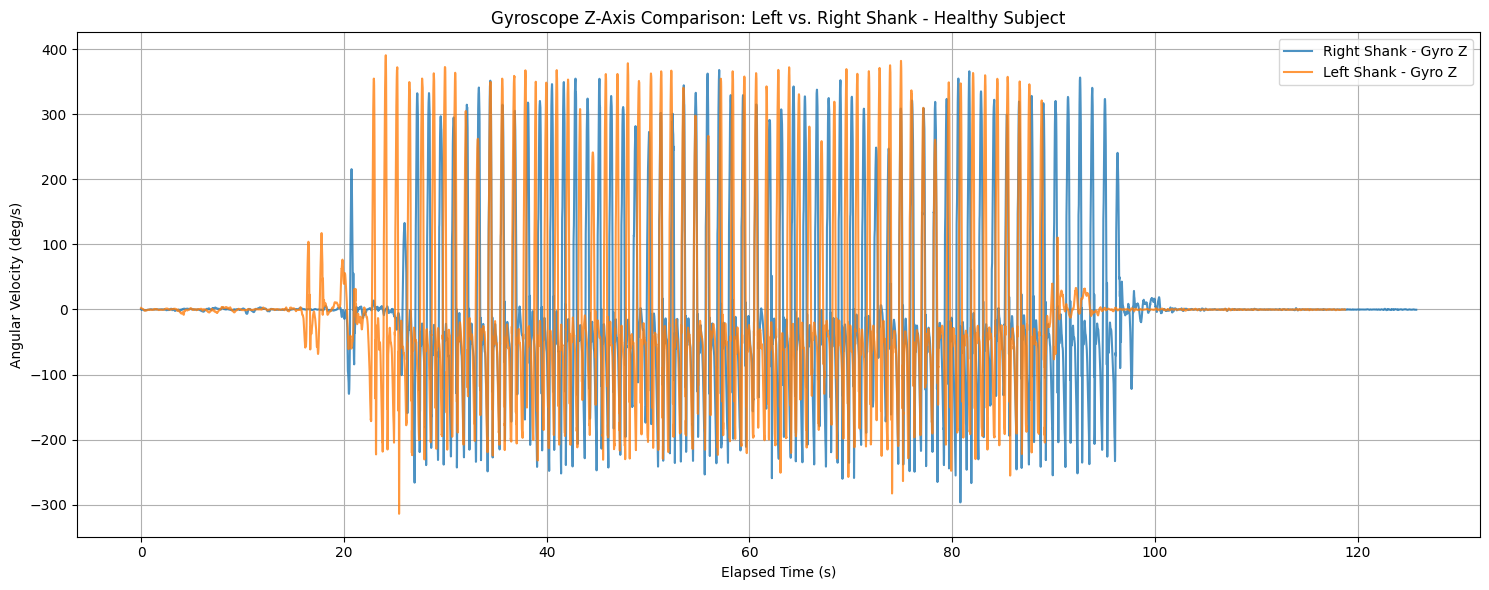

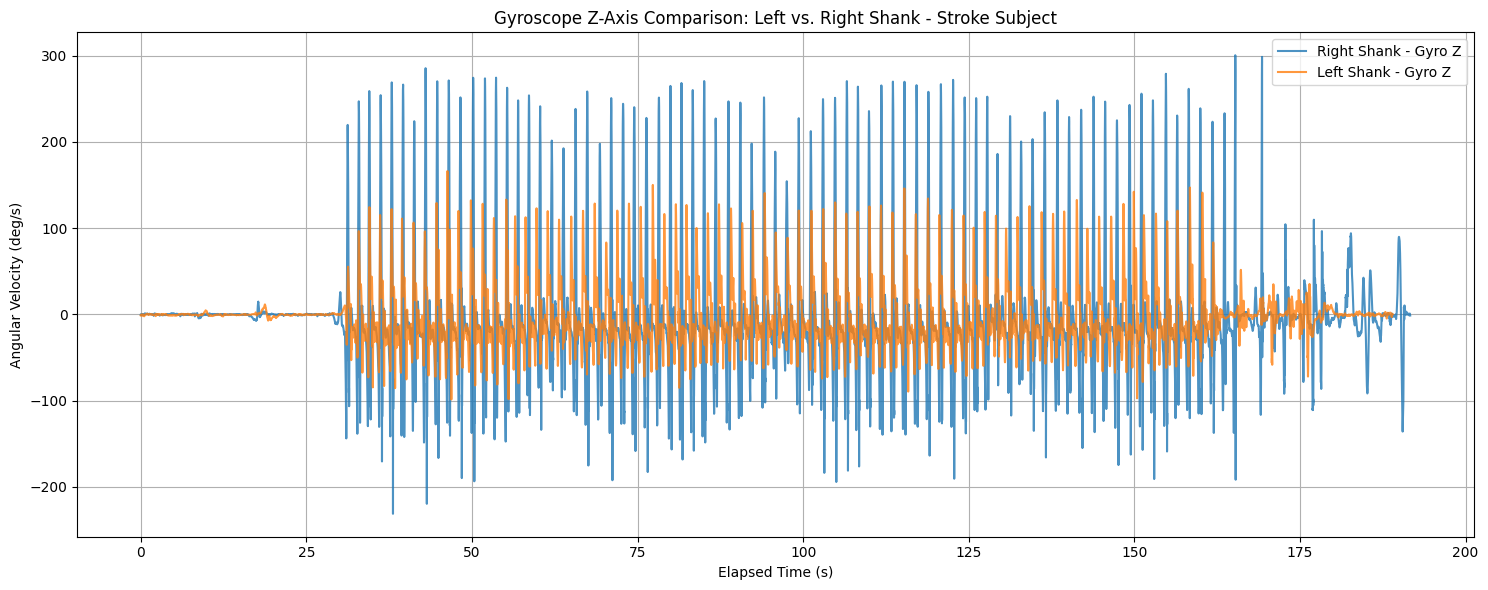

In [3]:
# File paths
healthy_gyro_right_path = os.path.join(healthy_directory, "Patient_5", "RightShank-Gyroscope.csv")
Healthy_gyro_left_path = os.path.join(healthy_directory,  "Patient_5", "LeftShank-Gyroscope.csv")

stroke_gyro_right_path = os.path.join(stroke_directory, "Patient_5", "RightShank-Gyroscope.csv")
stroke_gyro_left_path = os.path.join(stroke_directory,  "Patient_5", "LeftShank-Gyroscope.csv")

# Load data df_gyro_right
healthy_df_gyro_right = pd.read_csv(healthy_gyro_right_path)
healthy_df_gyro_left = pd.read_csv(Healthy_gyro_left_path)
stroke_df_gyro_right = pd.read_csv(stroke_gyro_right_path)
stroke_df_gyro_left = pd.read_csv(stroke_gyro_left_path)

# Plot for Healthy Subject
plot_gyro_comparison(
    title="Gyroscope Z-Axis Comparison: Left vs. Right Shank - Healthy Subject",
    df_right=healthy_df_gyro_right,
    df_left=healthy_df_gyro_left,
    axis_name="z-axis (deg/s)",
    label_right="Right Shank - Gyro Z",
    label_left="Left Shank - Gyro Z"
)

# Plot for Stroke Subject
plot_gyro_comparison(
    title="Gyroscope Z-Axis Comparison: Left vs. Right Shank - Stroke Subject",
    df_right=stroke_df_gyro_right,
    df_left=stroke_df_gyro_left,
    axis_name="z-axis (deg/s)",
    label_right="Right Shank - Gyro Z",
    label_left="Left Shank - Gyro Z"
)

## Interpretation:
- Both signals show cyclical waveforms, which correspond to leg swings during walking.
- The amplitude and frequency appear fairly symmetrical, as expected for a healthy subject.
- This kind of rhythm is what you'd want to analyze further for stride timing, swing/stance segmentation, and asymmetry detection.

---

## Butterworth low-pass filter

This function is used to preprocess gait data, such as gyroscope signals, by removing noise and retaining the essential low-frequency components for further analysis. 

In [4]:
# Define a low-pass Butterworth filter
def butterworth_lowpass_filter(data, cutoff=6, fs=100, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

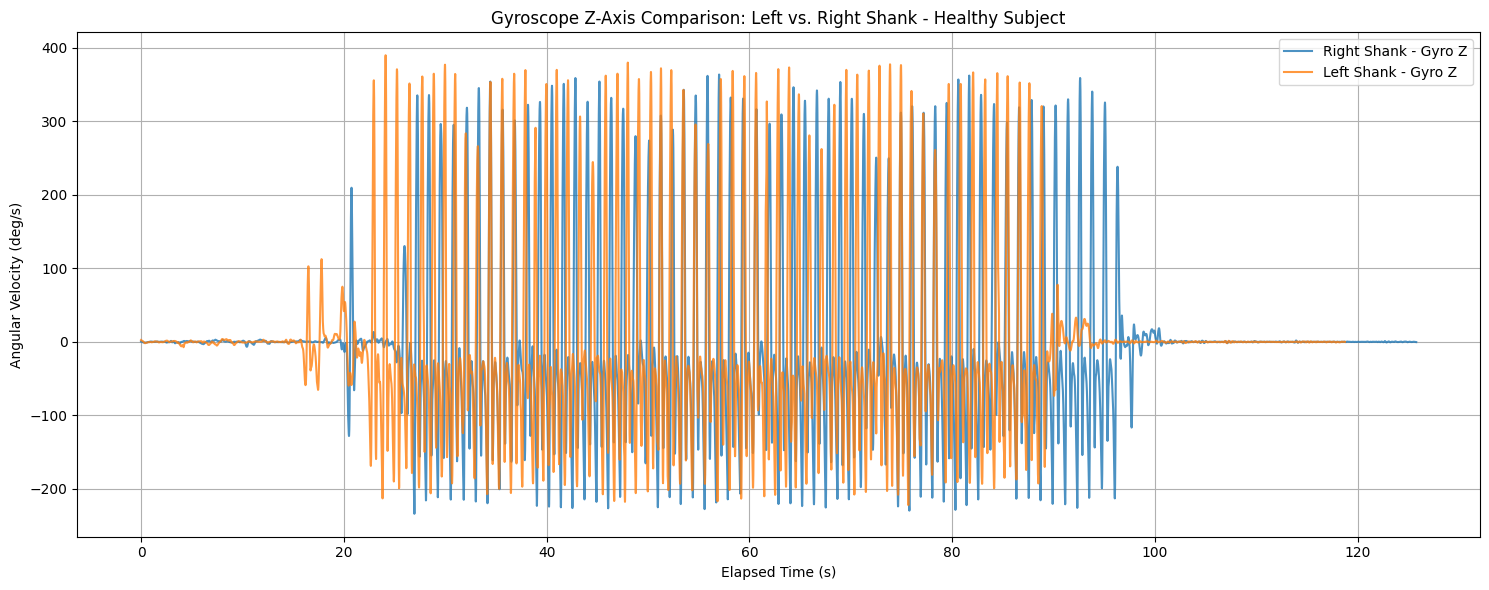

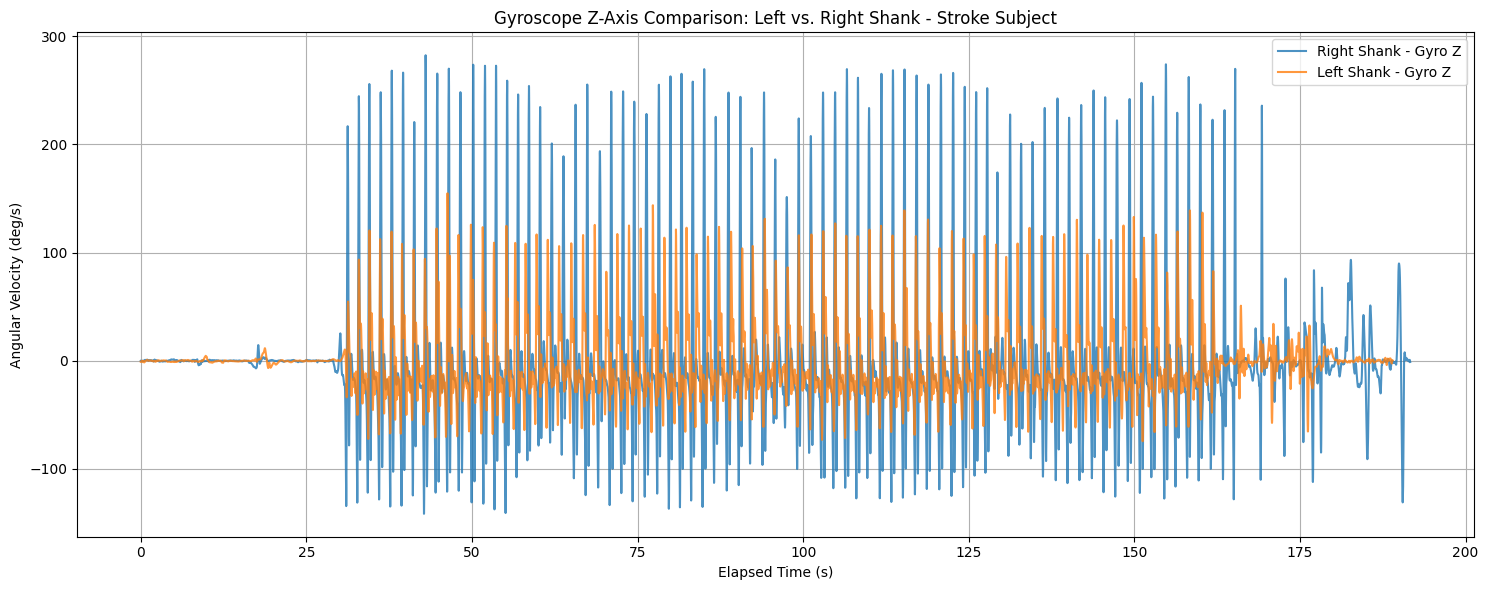

In [5]:
# Apply low pass filter to Z-axis gyroscope data for both legs
fs = 100
cutoff = 6

# Healthy Subject
healthy_df_gyro_right['z_filtered'] = butterworth_lowpass_filter(healthy_df_gyro_right['z-axis (deg/s)'], cutoff, fs)
healthy_df_gyro_left['z_filtered']  = butterworth_lowpass_filter(healthy_df_gyro_left['z-axis (deg/s)'], cutoff, fs)
plot_gyro_comparison(
    title="Gyroscope Z-Axis Comparison: Left vs. Right Shank - Healthy Subject",
    df_right=healthy_df_gyro_right,
    df_left=healthy_df_gyro_left,
    axis_name="z_filtered",
    label_right="Right Shank - Gyro Z",
    label_left="Left Shank - Gyro Z"
)

# Stroke Subject
stroke_df_gyro_right['z_filtered'] = butterworth_lowpass_filter(stroke_df_gyro_right['z-axis (deg/s)'], cutoff, fs)
stroke_df_gyro_left['z_filtered']  = butterworth_lowpass_filter(stroke_df_gyro_left['z-axis (deg/s)'], cutoff, fs)
plot_gyro_comparison(
    title="Gyroscope Z-Axis Comparison: Left vs. Right Shank - Stroke Subject",
    df_right=stroke_df_gyro_right,
    df_left=stroke_df_gyro_left,
    axis_name="z_filtered",
    label_right="Right Shank - Gyro Z",
    label_left="Left Shank - Gyro Z"
)

## Phase Detection 

This function will help us detect the two distinct phases of walking that includes:
1. **Stance phase**: In this phase the leg is planted on the ground, where the angular speed is zero.
2. **Swing Phase**: In this phase the leg is swinging to make a step, where we expect the angular velocity to increase, reach a maximum and then decrease again as the leg goes back to the stance phase.

In [6]:
# Function to detect zero-crossings and local minima
def detect_phases(signal, time):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    stance_swing = []

    for i in range(len(zero_crossings) - 1):
        start = zero_crossings[i]
        end = zero_crossings[i + 1]
        segment = signal[start:end]
        if len(segment) == 0:
            continue
        min_idx = np.argmin(segment) + start
        stance_swing.append({
            "stance_start": time[start],
            "stance_end": time[min_idx],
            "swing_start": time[min_idx],
            "swing_end": time[end]
        })
    return stance_swing

In [7]:
def plot_stance_detection(title, df, phases, label, color):
    plt.figure(figsize=(15, 6))
    
    plt.plot(df["elapsed (s)"], df["z_filtered"], label=label, color=color, alpha=0.8)
    for phase in phases:
        plt.axvspan(phase["stance_start"], phase["stance_end"], color='red', alpha=0.2)
        plt.axvspan(phase["swing_start"], phase["swing_end"], color='green', alpha=0.2)
    
    plt.title(title)
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("Filtered Angular Velocity (deg/s)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Stance Detaction based on sensor on Right Shank for both Healthy and Stroke Subjects

<Figure size 1500x600 with 0 Axes>

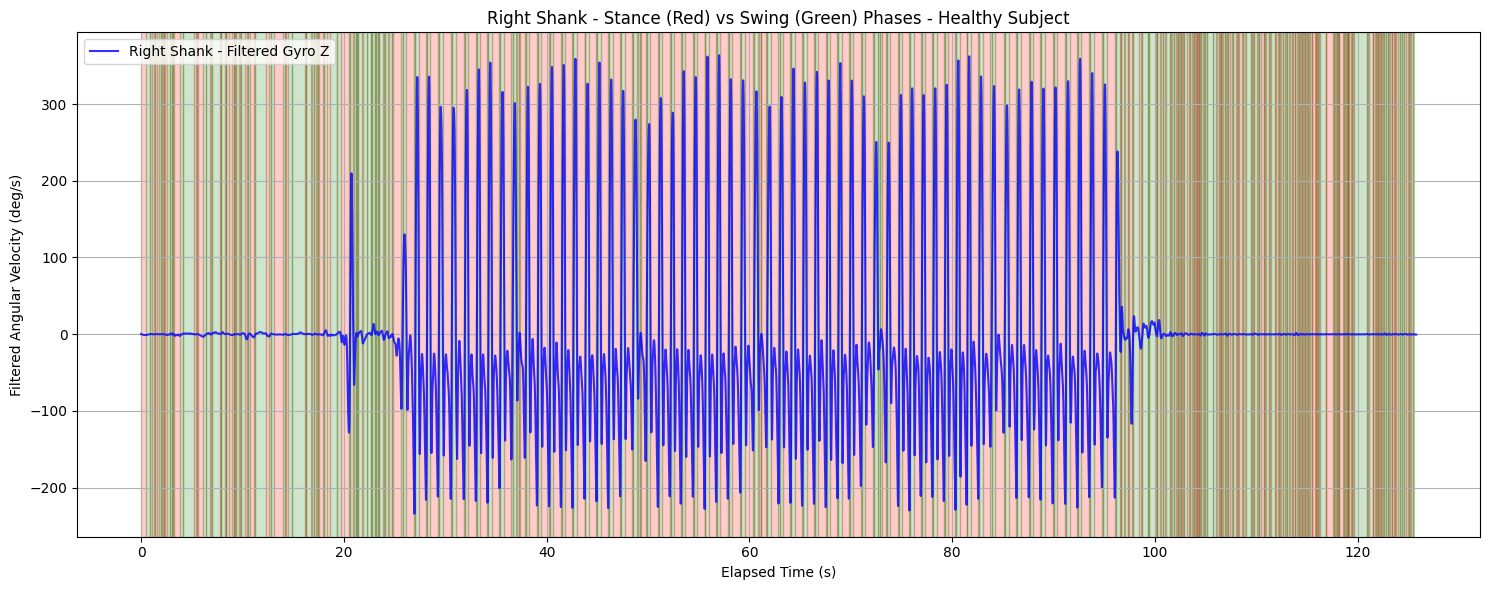

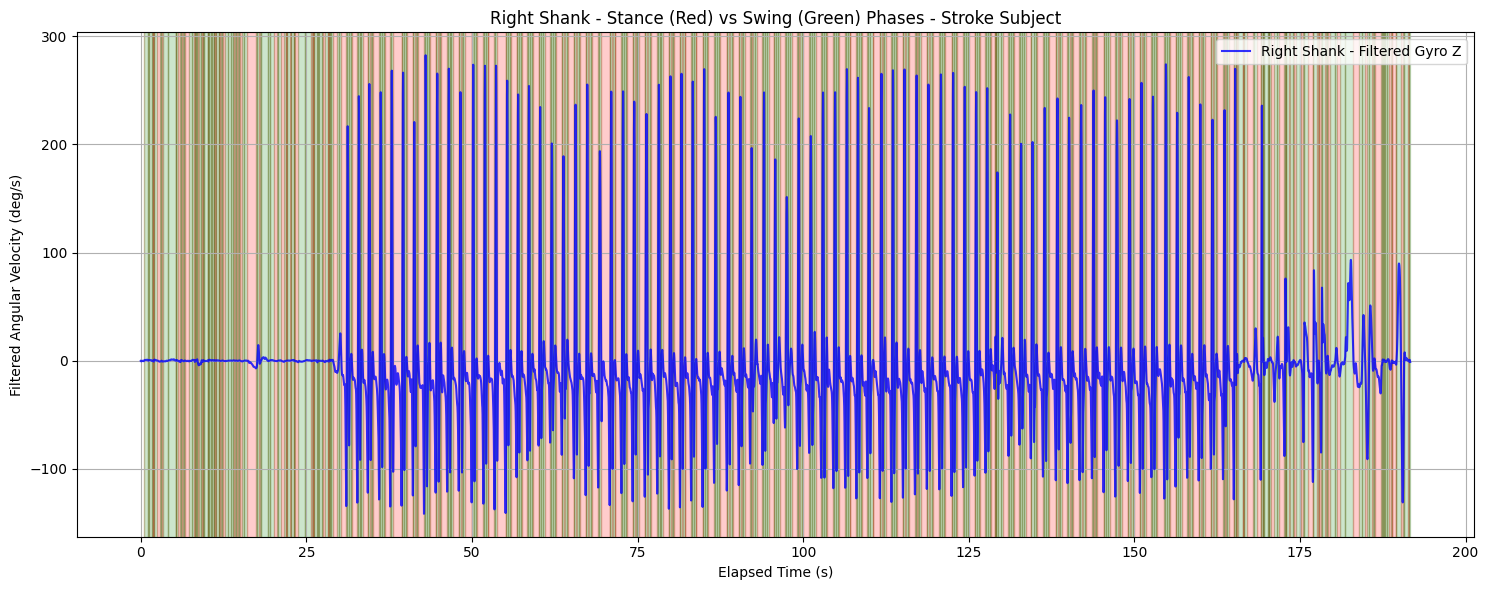

In [8]:
# Plot with highlighted stance and swing phases
plt.figure(figsize=(15, 6))


# Healthy Subject
healthy_phases_right = detect_phases(healthy_df_gyro_right["z_filtered"].values, healthy_df_gyro_right["elapsed (s)"].values)
plot_stance_detection(
    title="Right Shank - Stance (Red) vs Swing (Green) Phases - Healthy Subject",
    df=healthy_df_gyro_right,
    phases=healthy_phases_right,
    label="Right Shank - Filtered Gyro Z",
    color="blue"
)


# Stroke Subject
stroke_phases_right = detect_phases(stroke_df_gyro_right["z_filtered"].values, stroke_df_gyro_right["elapsed (s)"].values)
plot_stance_detection(
    title="Right Shank - Stance (Red) vs Swing (Green) Phases - Stroke Subject",
    df=stroke_df_gyro_right,
    phases=stroke_phases_right,
    label="Right Shank - Filtered Gyro Z",
    color="blue"
)

### Stance Detaction based on sensor on Left Shank for both Healthy and Stroke Subjects

<Figure size 1500x600 with 0 Axes>

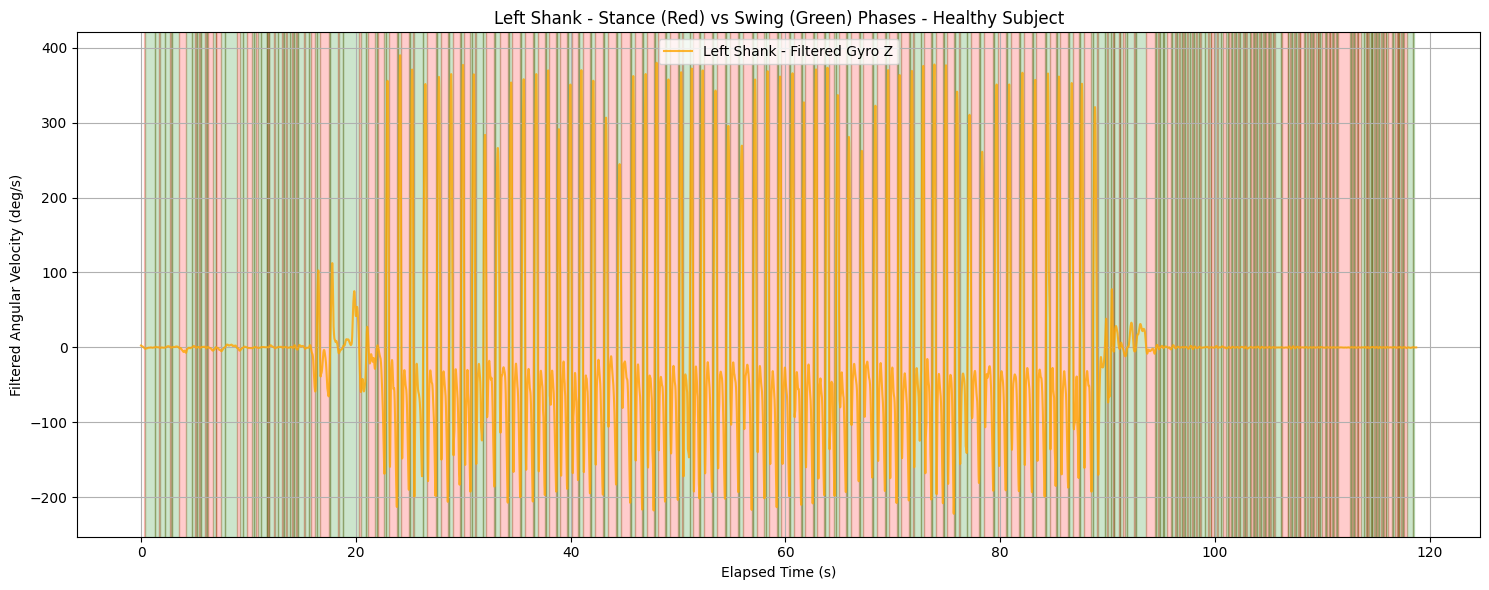

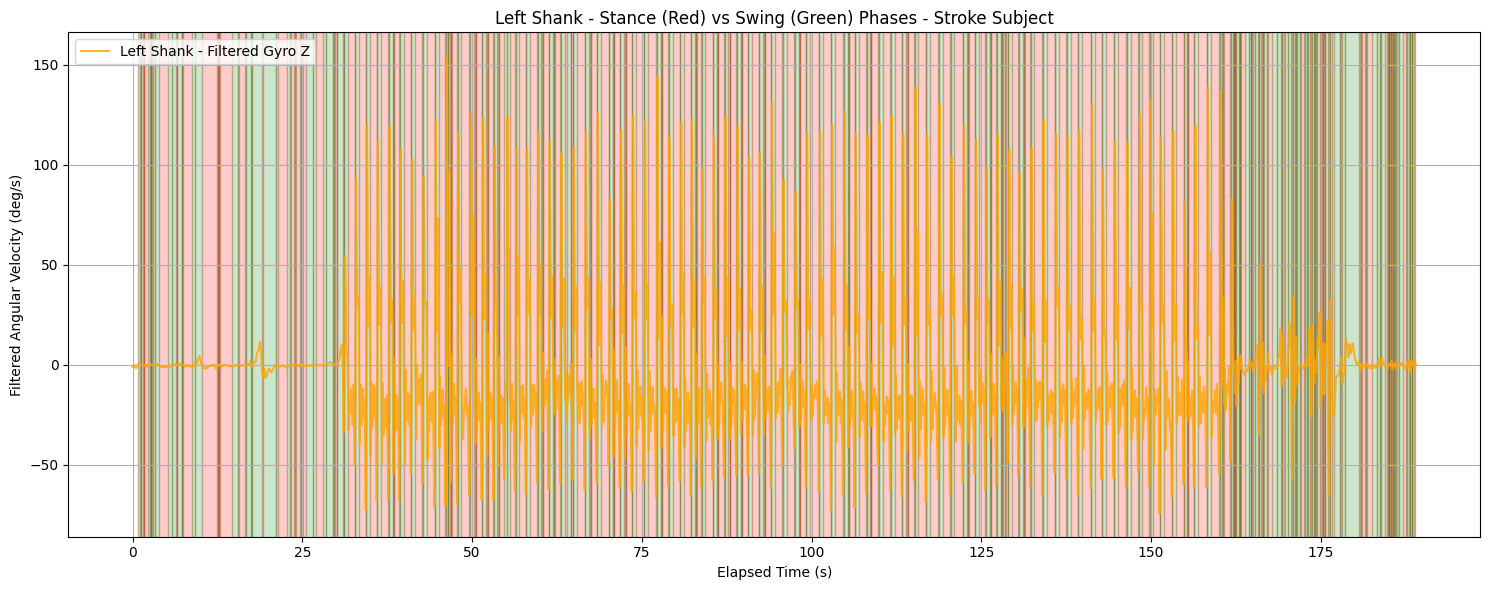

In [9]:
# Plot with highlighted stance and swing phases
plt.figure(figsize=(15, 6))

# Healthy Subject
healthy_phases_left = detect_phases(healthy_df_gyro_left["z_filtered"].values, healthy_df_gyro_left["elapsed (s)"].values)
plot_stance_detection(
    title="Left Shank - Stance (Red) vs Swing (Green) Phases - Healthy Subject",
    df=healthy_df_gyro_left,
    phases=healthy_phases_left,
    label="Left Shank - Filtered Gyro Z",
    color="orange"
)

# Stroke Subject
stroke_phases_left = detect_phases(stroke_df_gyro_left["z_filtered"].values, stroke_df_gyro_left["elapsed (s)"].values)
plot_stance_detection(
    title="Left Shank - Stance (Red) vs Swing (Green) Phases - Stroke Subject",
    df=stroke_df_gyro_left,
    phases=stroke_phases_left,
    label="Left Shank - Filtered Gyro Z",
    color="orange"
)


In [10]:
def plot_stance_comparison(title, df_right, df_left, phases_right, phases_left):
    plt.figure(figsize=(15, 6))
    
    plt.plot(df_right["elapsed (s)"], df_right["z_filtered"], label="Right Shank - Filtered Gyro Z", color='blue')
    plt.plot(df_left["elapsed (s)"], df_left["z_filtered"], label="Left Shank - Filtered Gyro Z", color='orange')

    # Overlay stance and swing phases
    for phase in phases_right:
        plt.axvspan(phase["stance_start"], phase["stance_end"], color='red', alpha=0.15, label='Right Stance' if phase == phases_right[0] else "")
        plt.axvspan(phase["swing_start"], phase["swing_end"], color='green', alpha=0.15, label='Right Swing' if phase == phases_right[0] else "")

    for phase in phases_left:
        plt.axvspan(phase["stance_start"], phase["stance_end"], color='pink', alpha=0.15, label='Left Stance' if phase == phases_left[0] else "")
        plt.axvspan(phase["swing_start"], phase["swing_end"], color='lightgreen', alpha=0.15, label='Left Swing' if phase == phases_left[0] else "")
    
    plt.title(title)
    plt.xlabel("Elapsed Time (s)")
    plt.ylabel("Filtered Angular Velocity (deg/s)")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

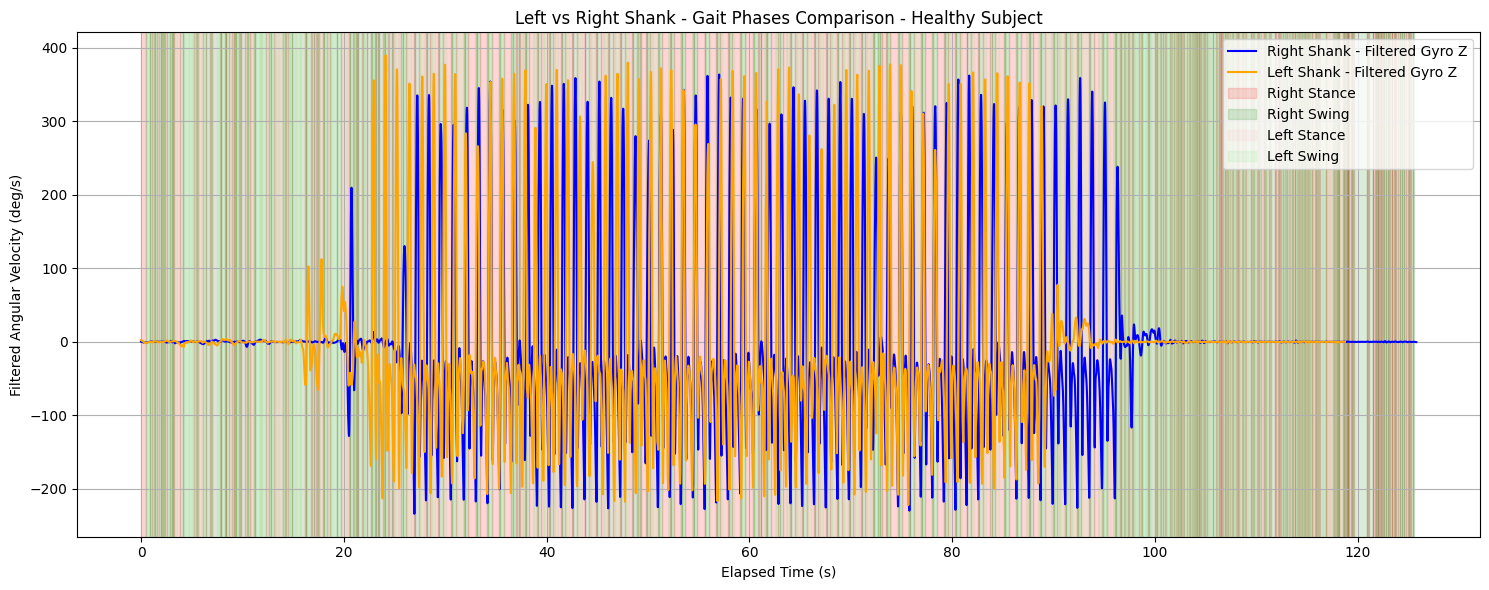

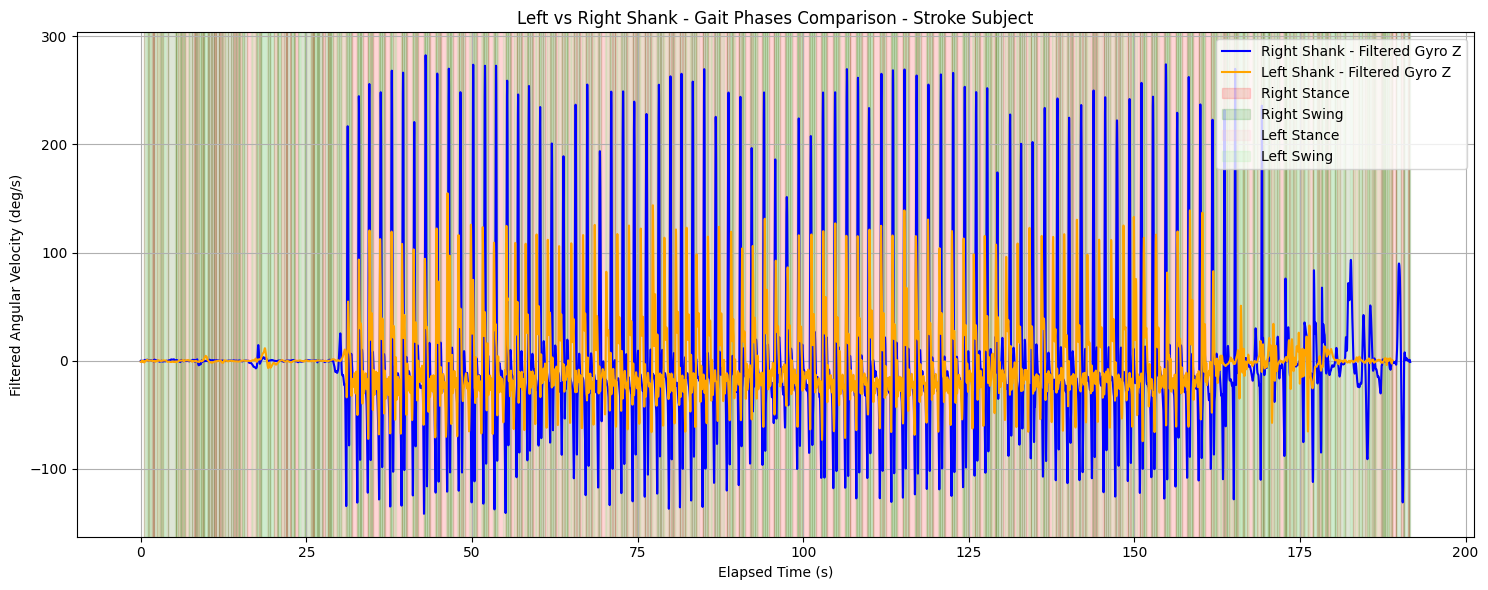

In [11]:
# Plot filtered Z-axis signals - Healthy Subject
plot_stance_comparison(
    title="Left vs Right Shank - Gait Phases Comparison - Healthy Subject",
    df_right=healthy_df_gyro_right,
    df_left=healthy_df_gyro_left,
    phases_right=healthy_phases_right,
    phases_left=healthy_phases_left
)

# Plot filtered Z-axis signals - Stroke Subject
plot_stance_comparison(
    title="Left vs Right Shank - Gait Phases Comparison - Stroke Subject",
    df_right=stroke_df_gyro_right,
    df_left=stroke_df_gyro_left,
    phases_right=stroke_phases_right,
    phases_left=stroke_phases_left
)

## Left Vs Right Shank - % Difference In Gait Phase Durations

Key Insights:
- Each point represents a gait cycle comparison between the two legs.
- Blue (circles): % difference in stance phase duration
- Orange (crosses): % difference in swing phase duration

The red dashed line at 10% is a common clinical threshold:
- Values above this may indicate gait asymmetry, often seen in post-stroke patients.

In [12]:
# Calculate durations and % differences
def calculate_durations(phases):
    stance_durations = []
    swing_durations = []
    for p in phases:
        stance_durations.append(p["stance_end"] - p["stance_start"])
        swing_durations.append(p["swing_end"] - p["swing_start"])
    return stance_durations, swing_durations

/var/folders/k5/22sywl_15k17yky84cqwzc_80000gn/T/ipykernel_28856/2964043473.py:10: RuntimeWarning: invalid value encountered in scalar divide
  stance_diff = [abs(stance_left[i] - stance_right[i]) / max(stance_left[i], stance_right[i]) * 100 for i in range(min_cycles)]


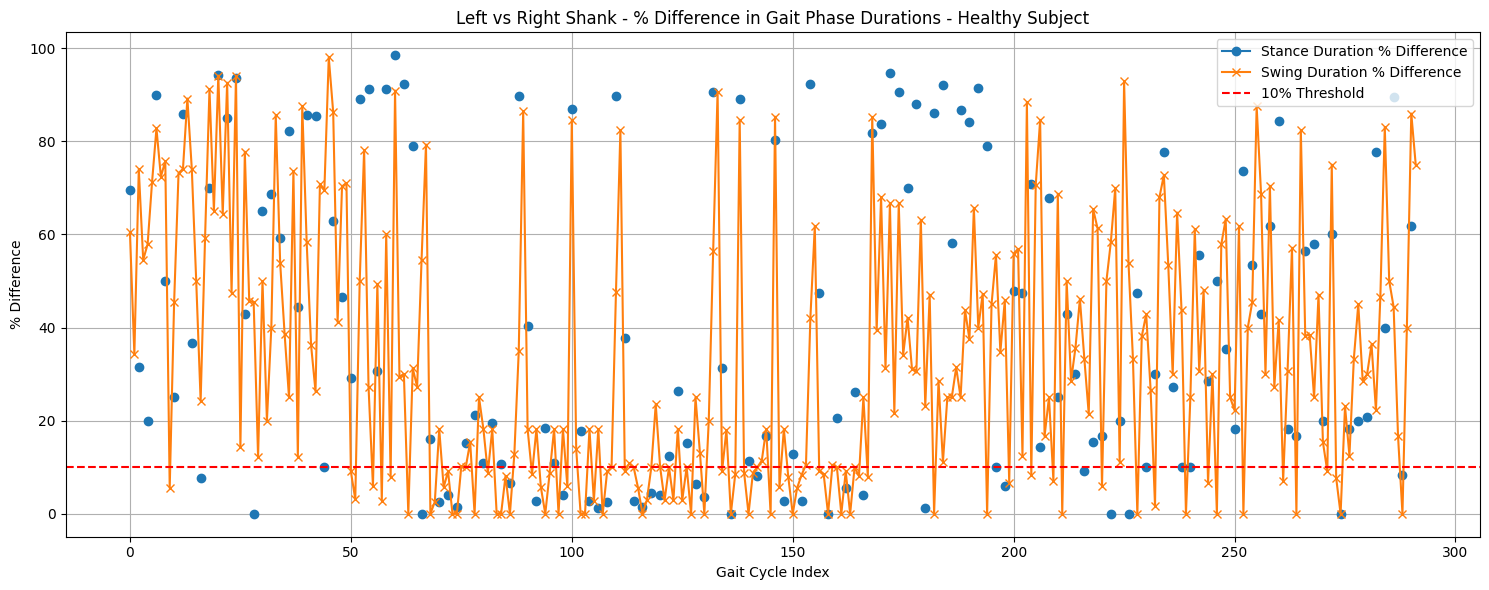

In [13]:
phases_left = detect_phases(healthy_df_gyro_left["z_filtered"].values, healthy_df_gyro_left["elapsed (s)"].values)
phases_right = detect_phases(healthy_df_gyro_right["z_filtered"].values, healthy_df_gyro_right["elapsed (s)"].values)



stance_left, swing_left = calculate_durations(phases_left)
stance_right, swing_right = calculate_durations(phases_right)

min_cycles = min(len(stance_left), len(stance_right))
stance_diff = [abs(stance_left[i] - stance_right[i]) / max(stance_left[i], stance_right[i]) * 100 for i in range(min_cycles)]
swing_diff = [abs(swing_left[i] - swing_right[i]) / max(swing_left[i], swing_right[i]) * 100 for i in range(min_cycles)]

# Plot the differences
plt.figure(figsize=(15, 6))
plt.plot(stance_diff, label="Stance Duration % Difference", marker='o')
plt.plot(swing_diff, label="Swing Duration % Difference", marker='x')
plt.axhline(10, color='red', linestyle='--', label="10% Threshold")
plt.title("Left vs Right Shank - % Difference in Gait Phase Durations - Healthy Subject")
plt.xlabel("Gait Cycle Index")
plt.ylabel("% Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/k5/22sywl_15k17yky84cqwzc_80000gn/T/ipykernel_28856/242362500.py:10: RuntimeWarning: invalid value encountered in scalar divide
  stance_diff = [abs(stance_left[i] - stance_right[i]) / max(stance_left[i], stance_right[i]) * 100 for i in range(min_cycles)]


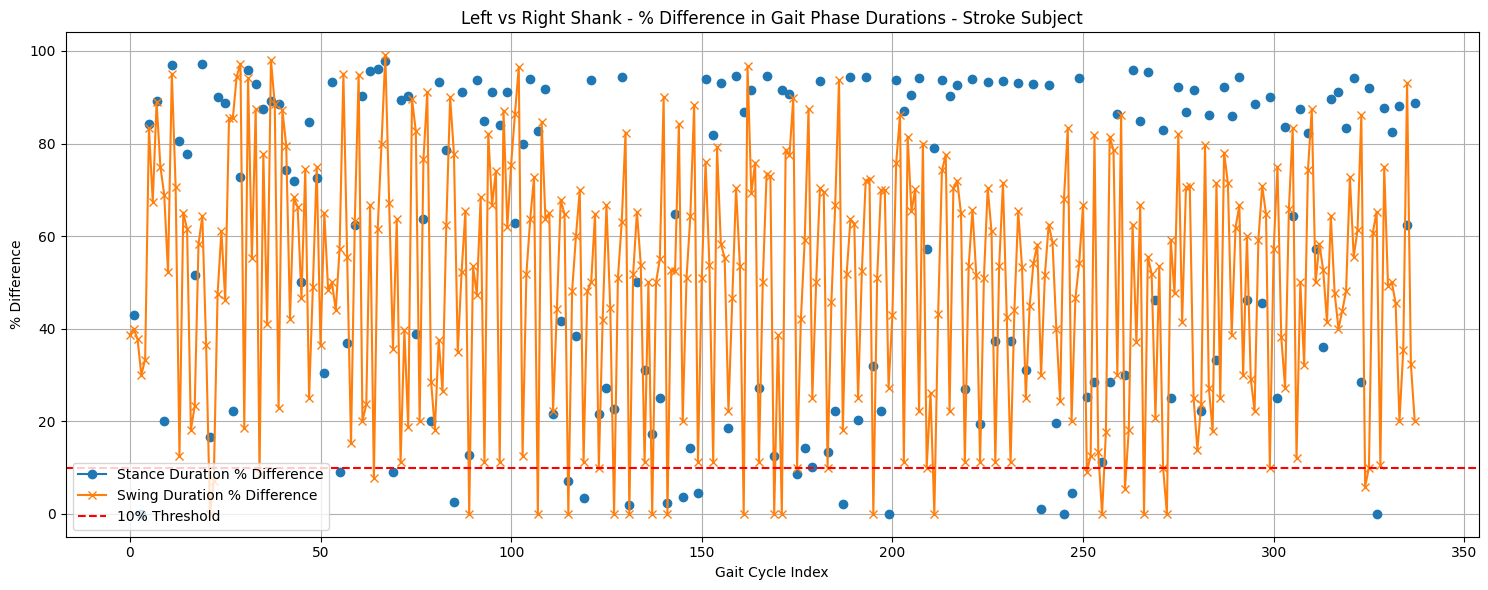

In [14]:
phases_left = detect_phases(stroke_df_gyro_left["z_filtered"].values, stroke_df_gyro_left["elapsed (s)"].values)
phases_right = detect_phases(stroke_df_gyro_right["z_filtered"].values, stroke_df_gyro_right["elapsed (s)"].values)



stance_left, swing_left = calculate_durations(phases_left)
stance_right, swing_right = calculate_durations(phases_right)

min_cycles = min(len(stance_left), len(stance_right))
stance_diff = [abs(stance_left[i] - stance_right[i]) / max(stance_left[i], stance_right[i]) * 100 for i in range(min_cycles)]
swing_diff = [abs(swing_left[i] - swing_right[i]) / max(swing_left[i], swing_right[i]) * 100 for i in range(min_cycles)]

# Plot the differences
plt.figure(figsize=(15, 6))
plt.plot(stance_diff, label="Stance Duration % Difference", marker='o')
plt.plot(swing_diff, label="Swing Duration % Difference", marker='x')
plt.axhline(10, color='red', linestyle='--', label="10% Threshold")
plt.title("Left vs Right Shank - % Difference in Gait Phase Durations - Stroke Subject")
plt.xlabel("Gait Cycle Index")
plt.ylabel("% Difference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Sync the time series for step-by-step alignment

Both time series now start and end at the same time, enabling direct step-by-step comparison.

This alignment allows accurate:
- Stride-to-stride symmetry analysis
- Model training with paired temporal features
- Phase shift evaluation

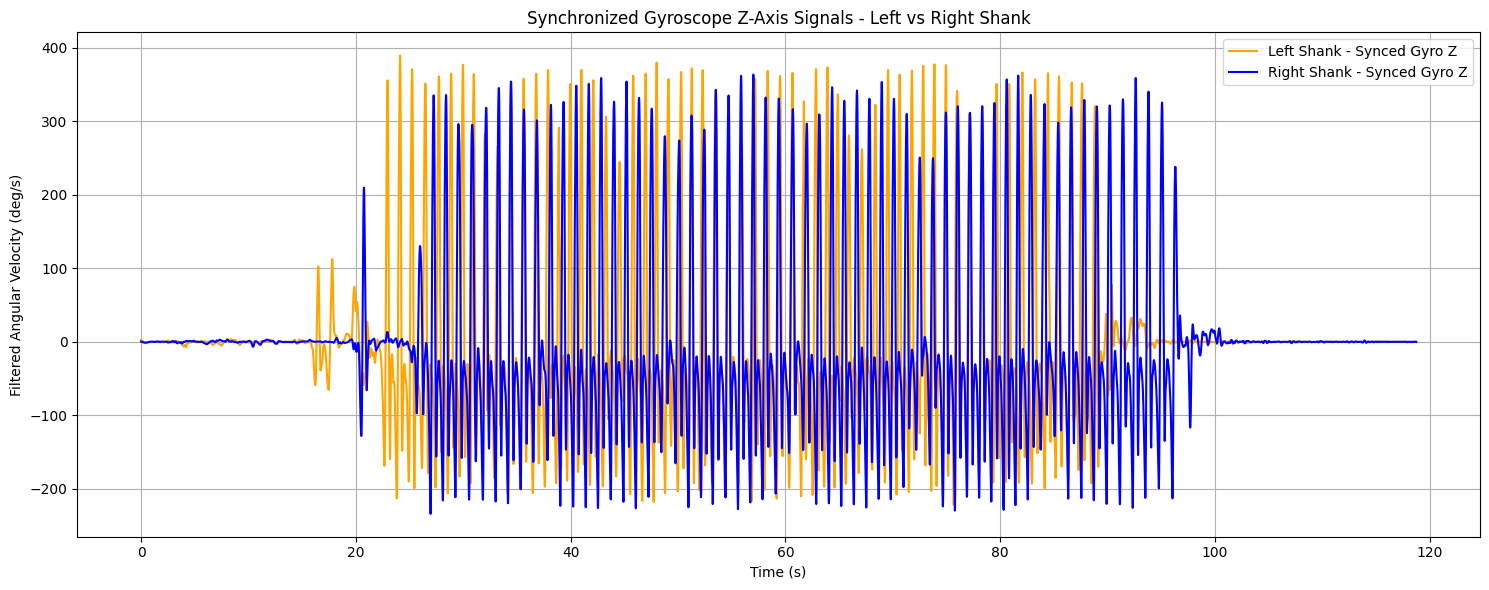

In [15]:
# Synchronize time series
start_time = max(healthy_df_gyro_left["elapsed (s)"].iloc[0], healthy_df_gyro_right["elapsed (s)"].iloc[0])
healthy_df_gyro_left["synced_time"] = healthy_df_gyro_left["elapsed (s)"] - start_time
healthy_df_gyro_right["synced_time"] = healthy_df_gyro_right["elapsed (s)"] - start_time

end_time = min(healthy_df_gyro_left["synced_time"].iloc[-1], healthy_df_gyro_right["synced_time"].iloc[-1])
healthy_df_gyro_left = healthy_df_gyro_left[healthy_df_gyro_left["synced_time"] <= end_time]
healthy_df_gyro_right = healthy_df_gyro_right[healthy_df_gyro_right["synced_time"] <= end_time]

# Plot synchronized signals
plt.figure(figsize=(15, 6))
plt.plot(healthy_df_gyro_left["synced_time"], healthy_df_gyro_left["z_filtered"], label="Left Shank - Synced Gyro Z", color='orange')
plt.plot(healthy_df_gyro_right["synced_time"], healthy_df_gyro_right["z_filtered"], label="Right Shank - Synced Gyro Z", color='blue')
plt.title("Synchronized Gyroscope Z-Axis Signals - Left vs Right Shank")
plt.xlabel("Time (s)")
plt.ylabel("Filtered Angular Velocity (deg/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

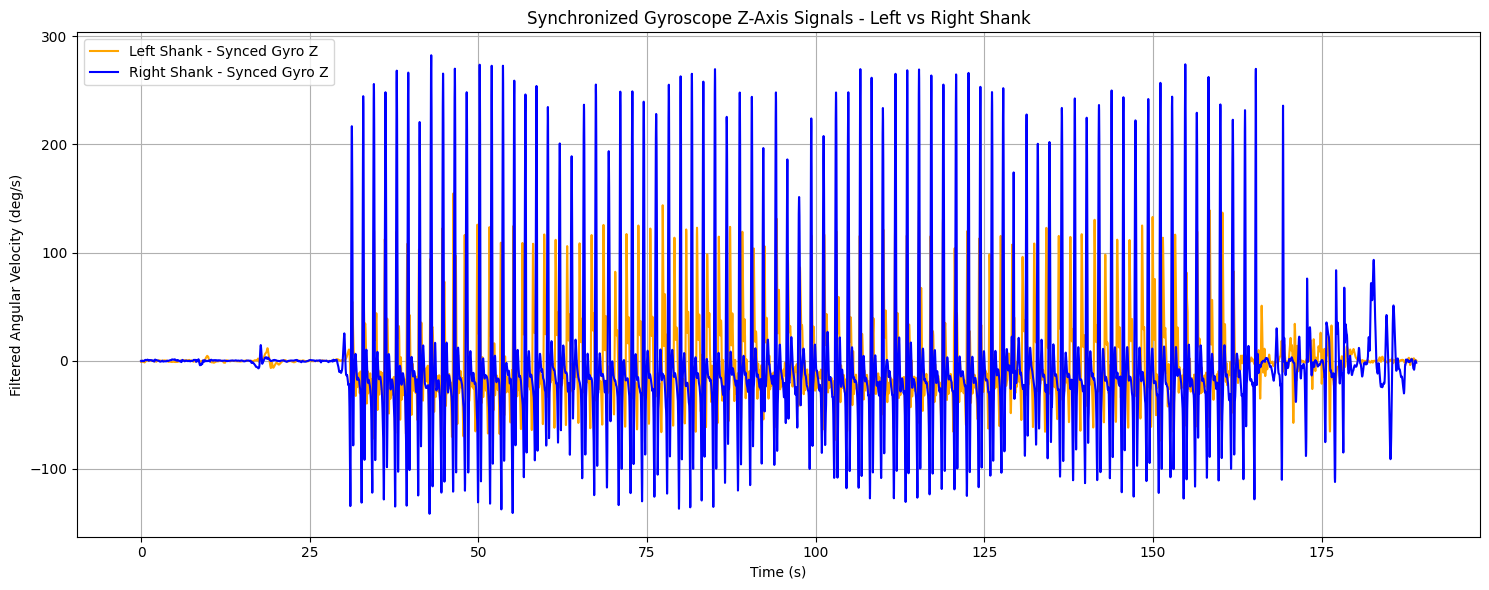

In [16]:
# Synchronize time series
start_time = max(stroke_df_gyro_left["elapsed (s)"].iloc[0], stroke_df_gyro_right["elapsed (s)"].iloc[0])
stroke_df_gyro_left["synced_time"]  = stroke_df_gyro_left["elapsed (s)"] - start_time
stroke_df_gyro_right["synced_time"] = stroke_df_gyro_right["elapsed (s)"] - start_time

end_time = min(stroke_df_gyro_left["synced_time"].iloc[-1], stroke_df_gyro_right["synced_time"].iloc[-1])
stroke_df_gyro_left  = stroke_df_gyro_left[stroke_df_gyro_left["synced_time"] <= end_time]
stroke_df_gyro_right = stroke_df_gyro_right[stroke_df_gyro_right["synced_time"] <= end_time]

# Plot synchronized signals
plt.figure(figsize=(15, 6))
plt.plot(stroke_df_gyro_left["synced_time"], stroke_df_gyro_left["z_filtered"], label="Left Shank - Synced Gyro Z", color='orange')
plt.plot(stroke_df_gyro_right["synced_time"], stroke_df_gyro_right["z_filtered"], label="Right Shank - Synced Gyro Z", color='blue')
plt.title("Synchronized Gyroscope Z-Axis Signals - Left vs Right Shank")
plt.xlabel("Time (s)")
plt.ylabel("Filtered Angular Velocity (deg/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()